In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import scanpy

import torch

from veloproj import *

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_umap_pca.h5',
                               '--model-name', 'Melania_Erythroid_mouse_model.cpt',
                               '--exp-name', 'CohAE_Melania_Erythroid_mouse',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'celltype',
                               '--scv_n_jobs', '10',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Erythroid1", "Erythroid2"), ('Erythroid2', "Erythroid3")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
par_path = "/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/notebooks/Melania_mouse/"
fast_data_path = "data.h5ad"
if fast_data_path in os.listdir(par_path):
    adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
else:
    adata = scanpy.read_h5ad(args.data_dir)
    sel = np.zeros(adata.n_obs, dtype=np.bool)
    sel = sel | (adata.obs.celltype == "Erythroid1").values | (adata.obs.celltype == "Erythroid2").values | (adata.obs.celltype == "Erythroid3").values
    sel = sel | (adata.obs.celltype == "Blood progenitors 1").values | sel | (adata.obs.celltype == "Blood progenitors 2").values
    adata = adata[sel]
    scv.utils.show_proportions(adata)
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
    scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
    scv.tl.velocity_confidence(adata, vkey='stc_velocity')
    
print(adata)



AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'celltype_colors', 'neighbors', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'stc_velocity_params'
    obsm: 'X_pca', 'X_

saving figure to file ./figures/scvelo_Melania_Erythroid_mouse_stochastical.png


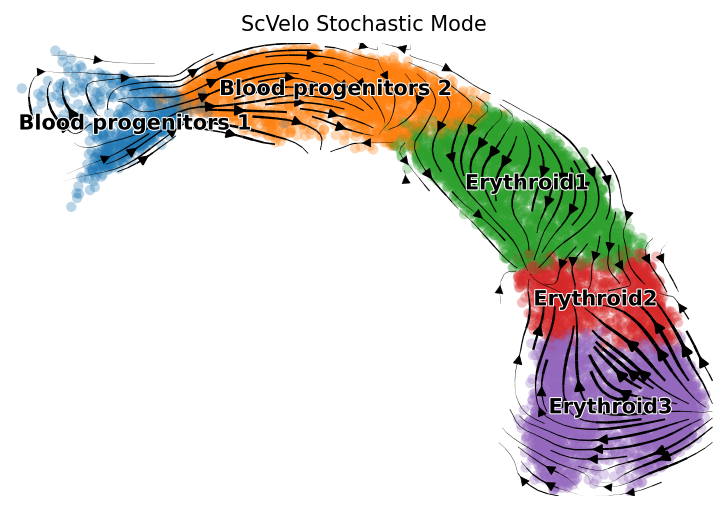

# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.17114995, ('Erythroid2', 'Erythroid3'): 0.09341168}
Total Mean: 0.13228081166744232
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.6864096, ('Erythroid2', 'Erythroid3'): 0.73946804}
Total Mean: 0.7129387855529785
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.35671440778567015, ('Erythroid2', 'Erythroid3'): -0.5571900059139028}
Total Mean: -0.10023779906411631
# In-cluster Coherence
{'Blood progenitors 1': 0.7551233, 'Blood progenitors 2': 0.7151811, 'Erythroid1': 0.70970446, 'Erythroid2': 0.7345957, 'Erythroid3': 0.8732634}
Total Mean: 0.7575736045837402
# In-cluster Confidence
{'Blood progenitors 1': 0.7300548396083746, 'Blood progenitors 2': 0.6358000902958937, 'Erythroid1': 0.7121040044950506, 'Erythroid2': 0.6815228624434411, 'Erythroid3': 0.9347134761548193}
Total Mean: 0.7388390545995158


In [7]:
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col, dpi=150,
                                title='ScVelo Stochastic Mode', save="Melania_Erythroid_mouse_stochastical.png")
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity", x_emb=args.vis_key)

Loss: (Total) 161.537704, (AE) 161.537323, (LR) 1.00 * 0.000387: 100%|██████████| 20000/20000 [23:25<00:00, 14.23it/s]


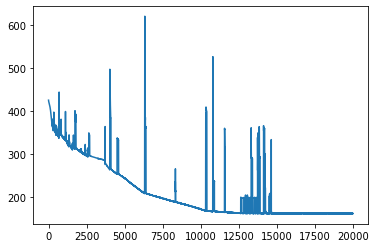

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/9815 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_Melania_Erythroid_mouse_pojection.png


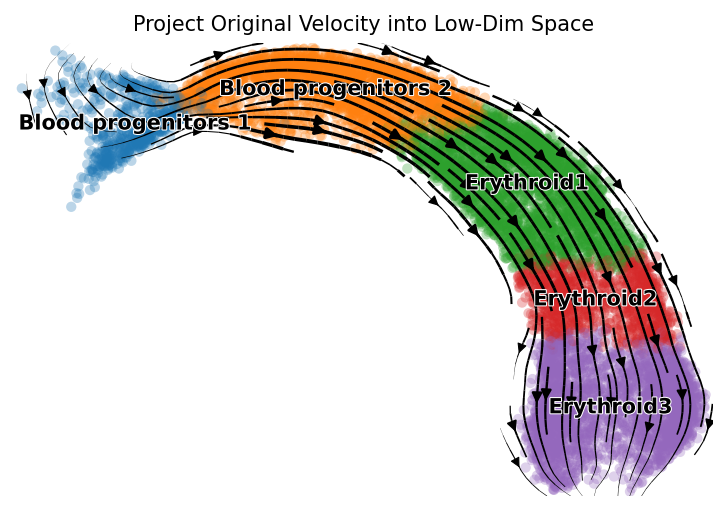

# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.7857183, ('Erythroid2', 'Erythroid3'): 0.7596499}
Total Mean: 0.7726840972900391
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.99984527, ('Erythroid2', 'Erythroid3'): 0.9998403}
Total Mean: 0.9998427629470825
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.8603992928431748, ('Erythroid2', 'Erythroid3'): 0.818012302051462}
Total Mean: 0.8392057974473184
# In-cluster Coherence
{'Blood progenitors 1': 0.9999318, 'Blood progenitors 2': 0.9999335, 'Erythroid1': 0.9999527, 'Erythroid2': 0.9998946, 'Erythroid3': 0.99989796}
Total Mean: 0.9999220967292786
# In-cluster Confidence
{'Blood progenitors 1': 0.9999112292621912, 'Blood progenitors 2': 0.9999152989406895, 'Erythroid1': 0.9999326838491394, 'Erythroid2': 0.9998609372978832, 'Erythroid3': 0.9998690920226169}
Total Mean: 0.999897848274504


In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=150,
                                    save='Melania_Erythroid_mouse_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity", x_emb=args.vis_key)
    
    
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.95 0.05]


  0%|          | 0/544 [00:00<?, ?gene/s]

  0%|          | 0/9815 [00:00<?, ?cells/s]

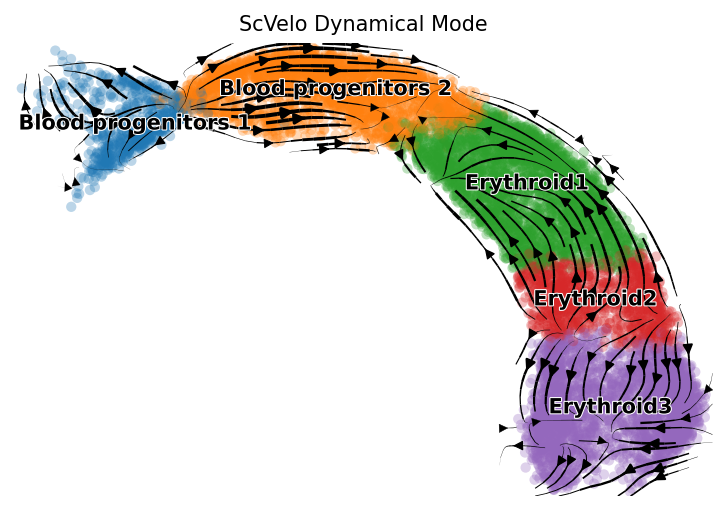

# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.035396256, ('Erythroid2', 'Erythroid3'): 0.044181738}
Total Mean: 0.039788998663425446
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.8532587144188156, ('Erythroid2', 'Erythroid3'): 0.8676007839253038}
Total Mean: 0.8604297491720597
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): -0.7794013755492345, ('Erythroid2', 'Erythroid3'): -0.22252181787128272}
Total Mean: -0.5009615967102586
# In-cluster Coherence
{'Blood progenitors 1': 0.8087588897054344, 'Blood progenitors 2': 0.8327418606024954, 'Erythroid1': 0.8877831248320902, 'Erythroid2': 0.8927056511740515, 'Erythroid3': 0.8643613143735124}
Total Mean: 0.8572701681375168
# In-cluster Confidence
{'Blood progenitors 1': 0.7939417365612198, 'Blood progenitors 2': 0.8231196677951897, 'Erythroid1': 0.8808469465004618, 'Erythroid2': 0.8839943263501511, 'Erythroid3': 0.858618575844734}
Total Mean: 0.8481042506103

In [10]:
adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [11]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)